<a href="https://colab.research.google.com/github/SaintNickG/Prediction-of-Product-Sales/blob/main/Copy_of_Prediction_of_Product_Sales(7).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product Sales Predictions
- By Nicholas Giuffrida


##  Imports


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import BaggingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import set_config
pd.set_option('display.max_columns', 100)
set_config(transform_output='pandas')
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.compose import make_column_transformer, make_column_selector

In [2]:
fname = "/content/drive/MyDrive/CodingDojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv"
# Save as a dataframe
df = pd.read_csv(fname)

In [3]:
df.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

##  Data Dictionary
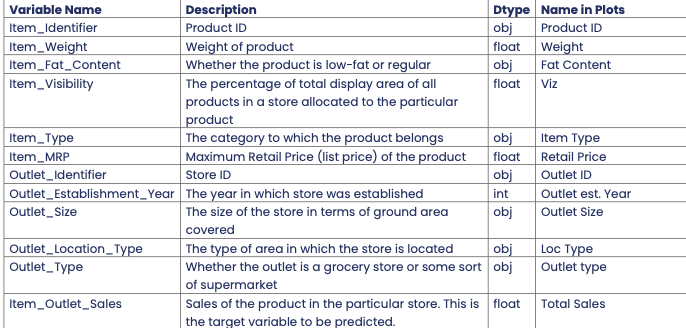

##  Inspect and Clean the Data

In [4]:
df.shape

(8523, 12)

**There are 8523 rows, and 12 columns of data.**

In [5]:
# Check the data types
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

**We see Object, Float, and Integer data types.**


### Duplicated Data
-  Checking for duplicated data:

In [6]:
df.duplicated().sum()

0

**There are no duplicated rows of data.**

## Missing Values
###  Checking for missing values:
- Identifying missing data

In [7]:
# Find missing values
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [8]:
# Display missing values as precentage of the column
df.isna().sum()/len(df) * 100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

**There is missing data in 2 of our columns.**
-  Item_Weight is missing 1463 (~17%) of it's values.
-  Outlet_Size is missing 2410 (~28%) of it's values.

### Check for Consistancy, and impossible values

In [9]:
# Identify string columns
string_cols = df.select_dtypes("object").columns
string_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [10]:
# Obtain the value counts for all string columns
for col in string_cols:
  print(f"Value Counts for {col}")
  print(df[col].value_counts())
  # Increasing readability by adding an empty line
  print('\n')

Value Counts for Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


Value Counts for Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Value Counts for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Value Counts for Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930


**There is an obvious correction needed.**
-  Item_Fat_Content has inconsistant values.
 -  We will rename the unnecessary values


In [11]:
# Standardize the values in the Fat Content column
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':"Low Fat",
                                                         'low fat':'Low Fat',
                                                         'reg':"Regular"})
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

**Now the coulmn has the correct value count.**

In [12]:
# Identify number columns
num_cols = df.select_dtypes("number").columns
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

In [13]:
df.describe()

Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  7060.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.643456         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       8.773750         0.026989    93.826500                1987.000000   
50%      12.600000         0.053931   143.012800                1999.000000   
75%      16.850000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800

**There are no obvious Impossible values**.

- The minimum value of zero *could* be impossible, but there are many reasons an item that is for sale may not be visible in the outlet were it is sold.
 - We will not treat The zero as an impossible value.



###  Rename columns
-  To make our plots read better, we will rename the columns.

In [14]:
# Create a dictionary to rename the columns
rename_dict = {"Item_Identifier":"Product ID", "Item_Weight":"Weight", "Item_Fat_Content":"Fat Content",
               "Item_Visibility":"Viz",
               "Item_Type":"Item Type",
               "Item_MRP":"Retail Price",
               "Outlet_Identifier":"Store ID",
               "Outlet_Establishment_Year":"Outlet est. Year",
               "Outlet_Size":"Outlet Size",
               "Outlet_Location_Type":"Loc Type",
               "Outlet_Type":"Outlet Type",
               "Item_Outlet_Sales":"Total Sales"}

In [15]:
# Use The rename dictionary to rename the columns
df = df.rename(rename_dict,axis=1)
df.head()

Product ID  Weight Fat Content       Viz              Item Type  \
0      FDA15    9.30     Low Fat  0.016047                  Dairy   
1      DRC01    5.92     Regular  0.019278            Soft Drinks   
2      FDN15   17.50     Low Fat  0.016760                   Meat   
3      FDX07   19.20     Regular  0.000000  Fruits and Vegetables   
4      NCD19    8.93     Low Fat  0.000000              Household   

   Retail Price Store ID  Outlet est. Year Outlet Size Loc Type  \
0      249.8092   OUT049              1999      Medium   Tier 1   
1       48.2692   OUT018              2009      Medium   Tier 3   
2      141.6180   OUT049              1999      Medium   Tier 1   
3      182.0950   OUT010              1998         NaN   Tier 3   
4       53.8614   OUT013              1987        High   Tier 3   

         Outlet Type  Total Sales  
0  Supermarket Type1    3735.1380  
1  Supermarket Type2     443.4228  
2  Supermarket Type1    2097.2700  
3      Grocery Store     732.3800  
4  Supermarket Type1     994.7052

## EDA
###  Custom functions will be important
-  Four custom fuctions for EDA.
 -  Two Custom fuctions for categorical features.
  -  Two for numeric features.

####  EDA Function to explore categorical columns

In [16]:
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):

  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}")

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax

####  EDA Function to Plot categorical columns against the Target

In [17]:
def plot_categorical_vs_target(df, x, y='Total Sales',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax

####  EDA Fuction to explore numeric columns

In [18]:
def explore_numeric(df, x, figsize=(6,5) ):
  # Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])
  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])
  ## Adding a title
  axes[0].set_title(f"Column: {x}")
  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()
  ## Print message with info on the count and % of null values
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")

####   EDA Function to plot numeric columns against Target

In [19]:
def plot_numeric_vs_target(df, x, y='Total Sales', figsize=(6,4)):
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)
  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})")
  # Make sure the plot is shown before the print statement
  plt.show()
  return fig, ax

##  EDA(categorical)
- We will exlore each categorical feature.
- We will plot each categorical feature against the target.

In [20]:
# set the style for seaborn
plt.style.use(['dark_background','seaborn-v0_8-muted', 'seaborn-v0_8-poster'])

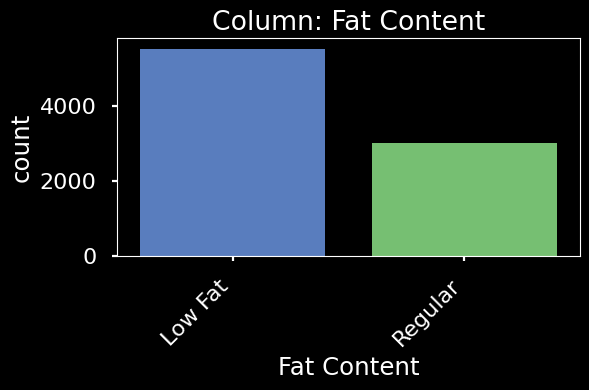

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Low Fat' occurs 5517 times (64.73%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Fat Content'}, xlabel='Fat Content', ylabel='count'>)

In [21]:
# Explore Fat content
explore_categorical(df, x ='Fat Content')

**This feature:**
 -  Has *no* missing values.
 - Has *low* cardinality (only 2 categories).
 - Is *not* constant(or quasi-constant).
 - This *categorical* feature *will be* included in our model


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Fat Content vs. Total Sales'}, xlabel='Fat Content', ylabel='Total Sales'>)

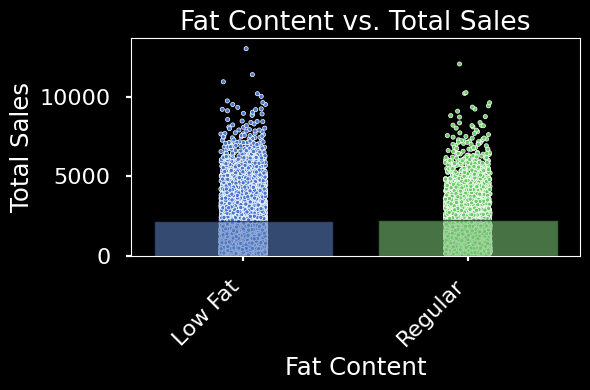

In [22]:
plot_categorical_vs_target(df, x = "Fat Content" )

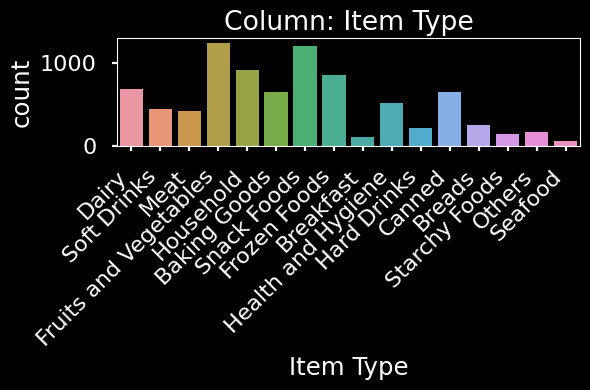

- NaN's Found: 0 (0.0%)
- Unique Values: 16
- Most common value: 'Fruits and Vegetables' occurs 1232 times (14.46%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Item Type'}, xlabel='Item Type', ylabel='count'>)

In [23]:
explore_categorical(df, x ='Item Type')

**This feature:**
 -  Has *no* missing values.
 - Has *high* cardinality (16 categories).
 - Is *not* constant(or quasi-constant).
 - This *categorical* feature *will be* included in our model

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Item Type vs. Total Sales'}, xlabel='Item Type', ylabel='Total Sales'>)

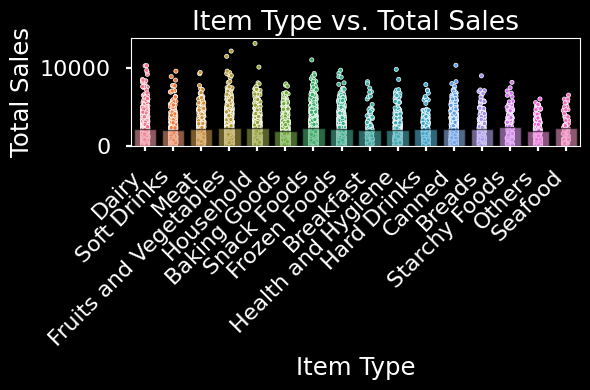

In [24]:
plot_categorical_vs_target(df, x = "Item Type" )

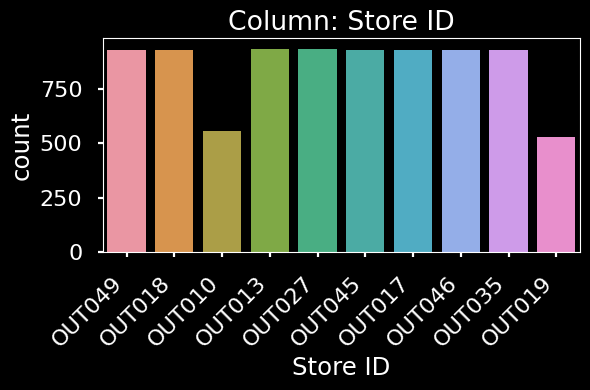

- NaN's Found: 0 (0.0%)
- Unique Values: 10
- Most common value: 'OUT027' occurs 935 times (10.97%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Store ID'}, xlabel='Store ID', ylabel='count'>)

In [25]:
explore_categorical(df, x = 'Store ID')

**This feature:**
 -  Has *no* missing values.
 - Has *high* cardinality (10 categories).
 - Is *not* constant(or quasi-constant).
 - This *categorical* feature *will not be* included in our model

**This feature:**
 -  Has *no* missing values.
 - Has ** cardinality (10 categories).
 - Is *not* constant(or quasi-constant).
 - This *categorical* feature *will be* included in our model

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Store ID vs. Total Sales'}, xlabel='Store ID', ylabel='Total Sales'>)

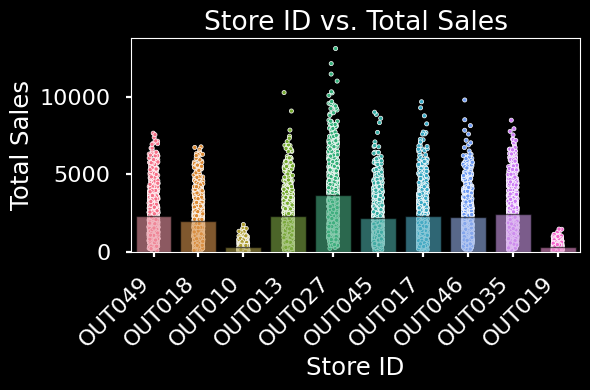

In [26]:
plot_categorical_vs_target(df, x = 'Store ID')

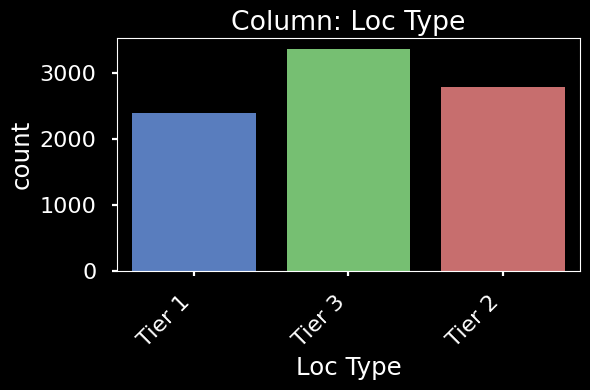

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'Tier 3' occurs 3350 times (39.31%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Loc Type'}, xlabel='Loc Type', ylabel='count'>)

In [27]:
explore_categorical(df, x = 'Loc Type')

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Loc Type vs. Total Sales'}, xlabel='Loc Type', ylabel='Total Sales'>)

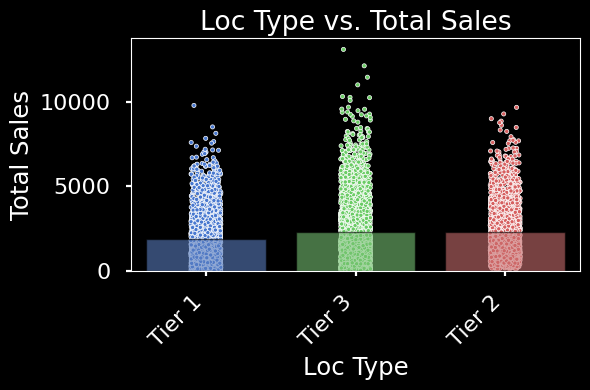

In [28]:
plot_categorical_vs_target(df, x = 'Loc Type')

**This feature:**
 -  Has *no* missing values.
 - Has *low* cardinality (only 3 categories).
 - Is *not* constant(or quasi-constant).
 - This *categorical* feature *will be* included in our model

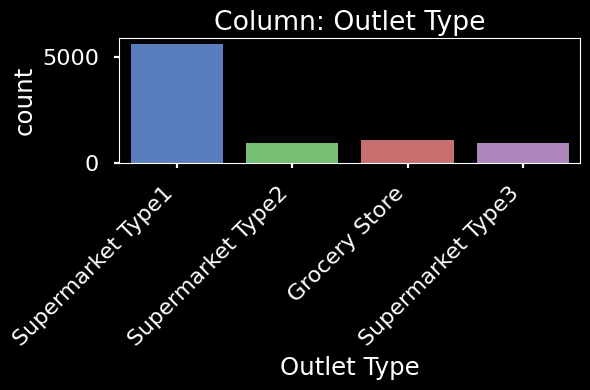

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: 'Supermarket Type1' occurs 5577 times (65.43%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Outlet Type'}, xlabel='Outlet Type', ylabel='count'>)

In [29]:
explore_categorical(df, x = 'Outlet Type')

**This feature:**
 -  Has *no* missing values.
 - Has *low* cardinality (only 4 categories).
 - Is *not* constant(or quasi-constant).
 - This *categorical* feature *will be* included in our model

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Outlet Type vs. Total Sales'}, xlabel='Outlet Type', ylabel='Total Sales'>)

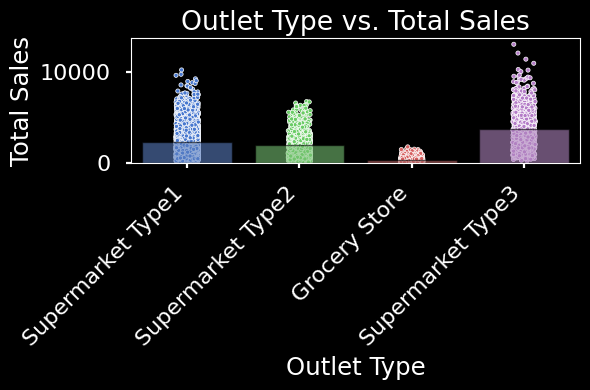

In [30]:
plot_categorical_vs_target(df, x = 'Outlet Type')

In [31]:
obj_cols = df.select_dtypes("object").columns
obj_cols

Index(['Product ID', 'Fat Content', 'Item Type', 'Store ID', 'Outlet Size',
       'Loc Type', 'Outlet Type'],
      dtype='object')

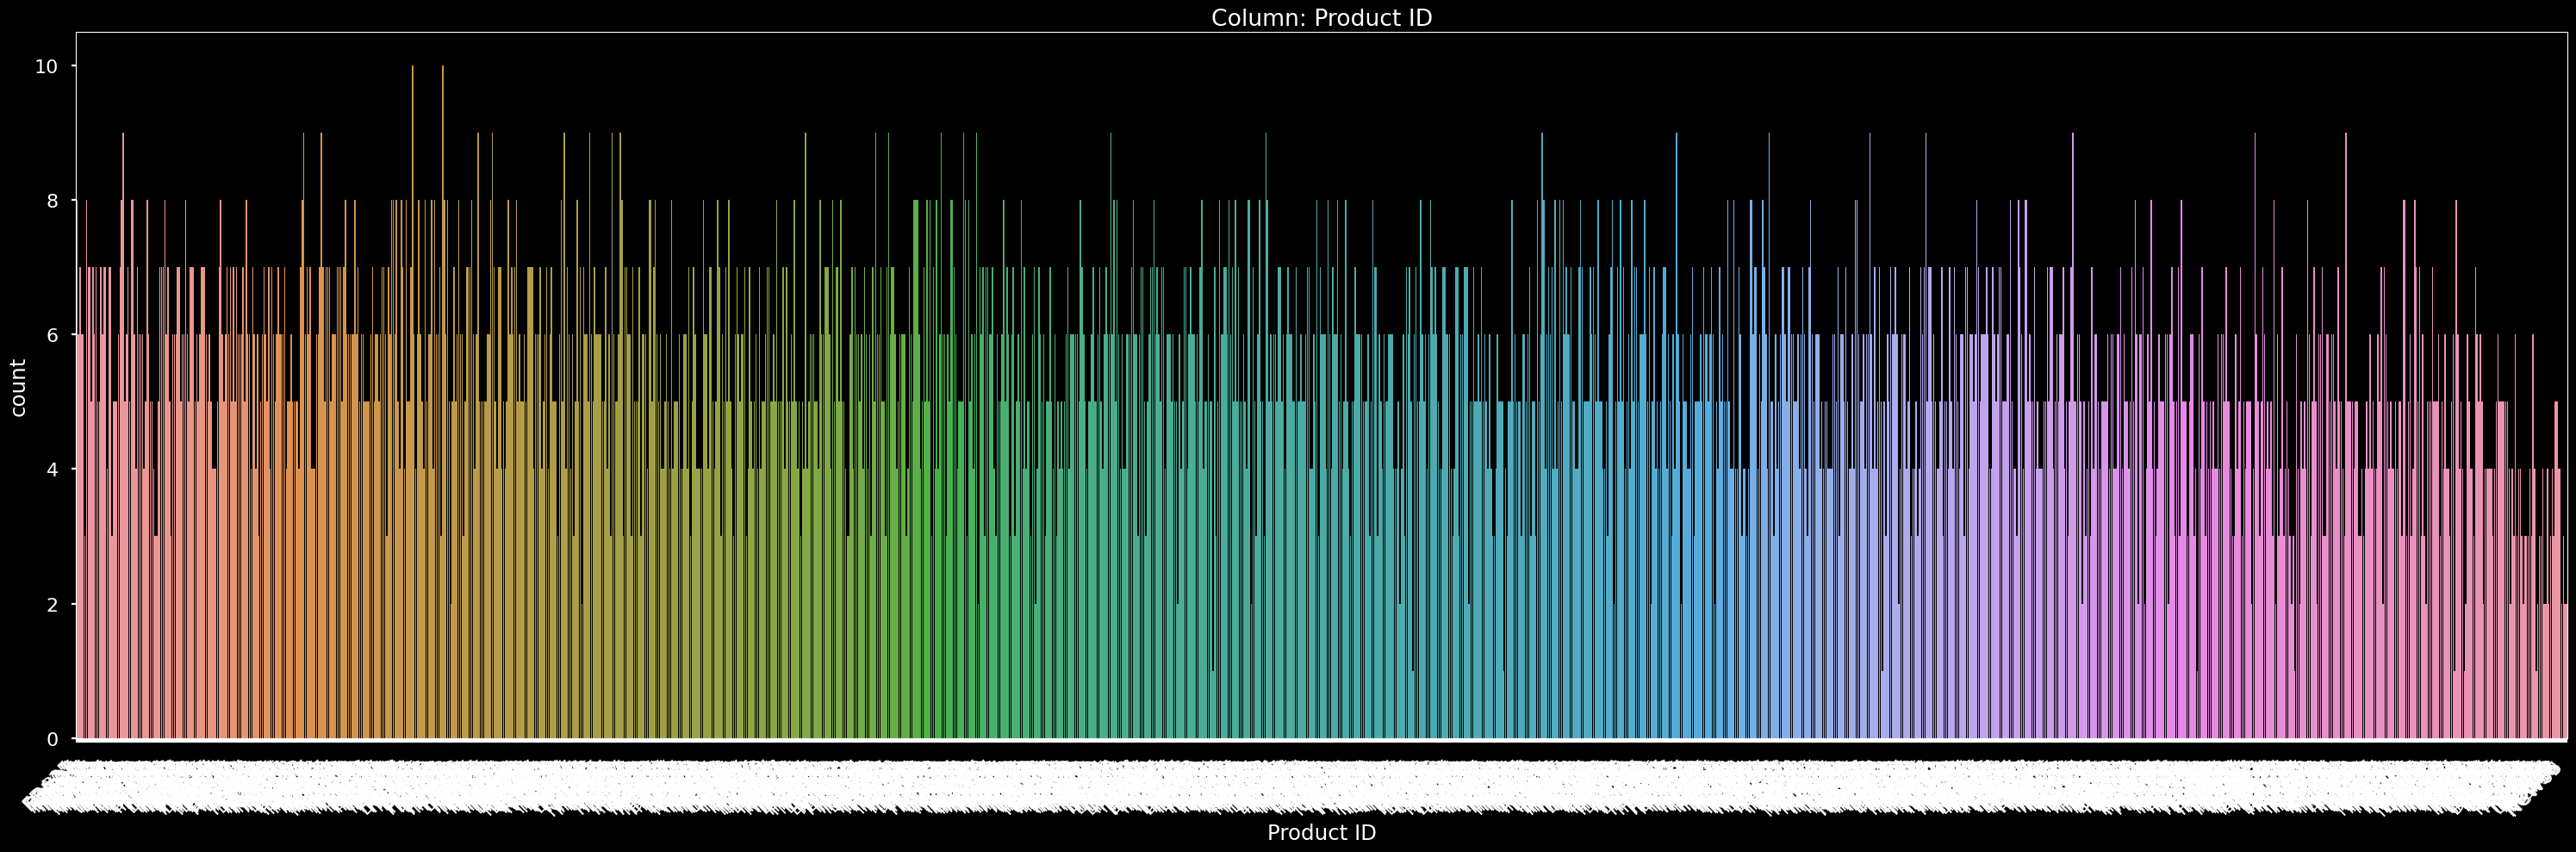

- NaN's Found: 0 (0.0%)
- Unique Values: 1559
- Most common value: 'FDW13' occurs 10 times (0.12%)
- Not constant or quasi-constant.


(<Figure size 3000x1000 with 1 Axes>,
 <Axes: title={'center': 'Column: Product ID'}, xlabel='Product ID', ylabel='count'>)

In [32]:
explore_categorical(df, x = 'Product ID', figsize=(30, 10))

**This feature:**
 -  Has *no* missing values.
 - Has *extremely high* cardinality (1559 categories).
 - Is *not* constant(or quasi-constant).
 - This *categorical* feature *will not be* included in our model.

###  Outlet Size
-  I have chosed to explore and plot *Outlet Size* last becaue it has missing values.
-  I will perform additional Exploratory techniques to determine how to deal with the missing values.

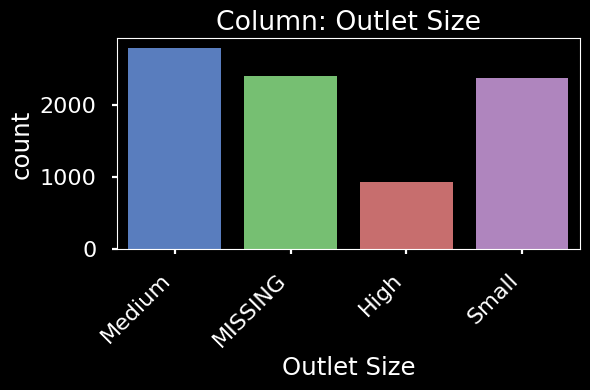

- NaN's Found: 2410 (28.28%)
- Unique Values: 4
- Most common value: 'Medium' occurs 2793 times (32.77%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Outlet Size'}, xlabel='Outlet Size', ylabel='count'>)

In [33]:
explore_categorical(df, x = 'Outlet Size')

**This feature:**
 -  Has *2410* missing values (28.28%).
 - Has *low* cardinality (only 3 categories).
 - Is *not* constant(or quasi-constant).
 - This *categorical* feature *will be* included in our model

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Outlet Size vs. Total Sales'}, xlabel='Outlet Size', ylabel='Total Sales'>)

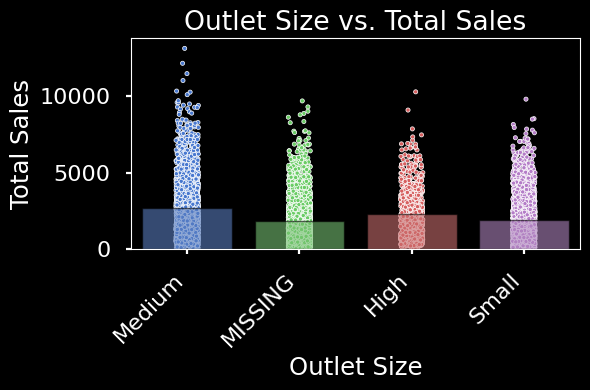

In [34]:
plot_categorical_vs_target(df, x = 'Outlet Size')

**We will need a strategy to deal with the missing values.**
-  The most common value is in the *Medium* category.
-  We will do some additional exploration.

In [35]:
# Create a filter to view the rows with missing data
missing_rows = df['Outlet Size'].isna()
df[missing_rows]

Product ID  Weight Fat Content       Viz              Item Type  \
3         FDX07  19.200     Regular  0.000000  Fruits and Vegetables   
8         FDH17  16.200     Regular  0.016687           Frozen Foods   
9         FDU28  19.200     Regular  0.094450           Frozen Foods   
25        NCD06  13.000     Low Fat  0.099887              Household   
28        FDE51   5.925     Regular  0.161467                  Dairy   
...         ...     ...         ...       ...                    ...   
8502      NCH43   8.420     Low Fat  0.070712              Household   
8508      FDW31  11.350     Regular  0.043246  Fruits and Vegetables   
8509      FDG45   8.100     Low Fat  0.214306  Fruits and Vegetables   
8514      FDA01  15.000     Regular  0.054489                 Canned   
8519      FDS36   8.380     Regular  0.046982           Baking Goods   

      Retail Price Store ID  Outlet est. Year Outlet Size Loc Type  \
3         182.0950   OUT010              1998         NaN   Tier 3   
8          96.9726   OUT045              2002         NaN   Tier 2   
9         187.8214   OUT017              2007         NaN   Tier 2   
25         45.9060   OUT017              2007         NaN   Tier 2   
28         45.5086   OUT010              1998         NaN   Tier 3   
...            ...      ...               ...         ...      ...   
8502      216.4192   OUT045              2002         NaN   Tier 2   
8508      199.4742   OUT045              2002         NaN   Tier 2   
8509      213.9902   OUT010              1998         NaN   Tier 3   
8514       57.5904   OUT045              2002         NaN   Tier 2   
8519      108.1570   OUT045              2002         NaN   Tier 2   

            Outlet Type  Total Sales  
3         Grocery Store     732.3800  
8     Supermarket Type1    1076.5986  
9     Supermarket Type1    4710.5350  
25    Supermarket Type1     838.9080  
28        Grocery Store     178.4344  
...                 ...          ...  
8502  Supermarket Type1    3020.0688  
8508  Supermarket Type1    2587.9646  
8509      Grocery Store     424.7804  
8514  Supermarket Type1     468.7232  
8519  Supermarket Type1     549.2850  

[2410 rows x 12 columns]

  **We notice that**
  -  All of the missing values for *Outlet Size* are in the Supermarket Type 1 and Grocery Store *Outlet Type*.
  -  All of the missing values values for *Outlet Size* are in the Tier 2 and Tier 3 *Loc Type.*
  -  There are 3 *Store ID* with Missing values.
  -  Both Missing values from "Supermarket Type 1" are In "Tier 2" *Loc Type*.
   -  We will plot *Outlet Type* and *Outlet Size*.


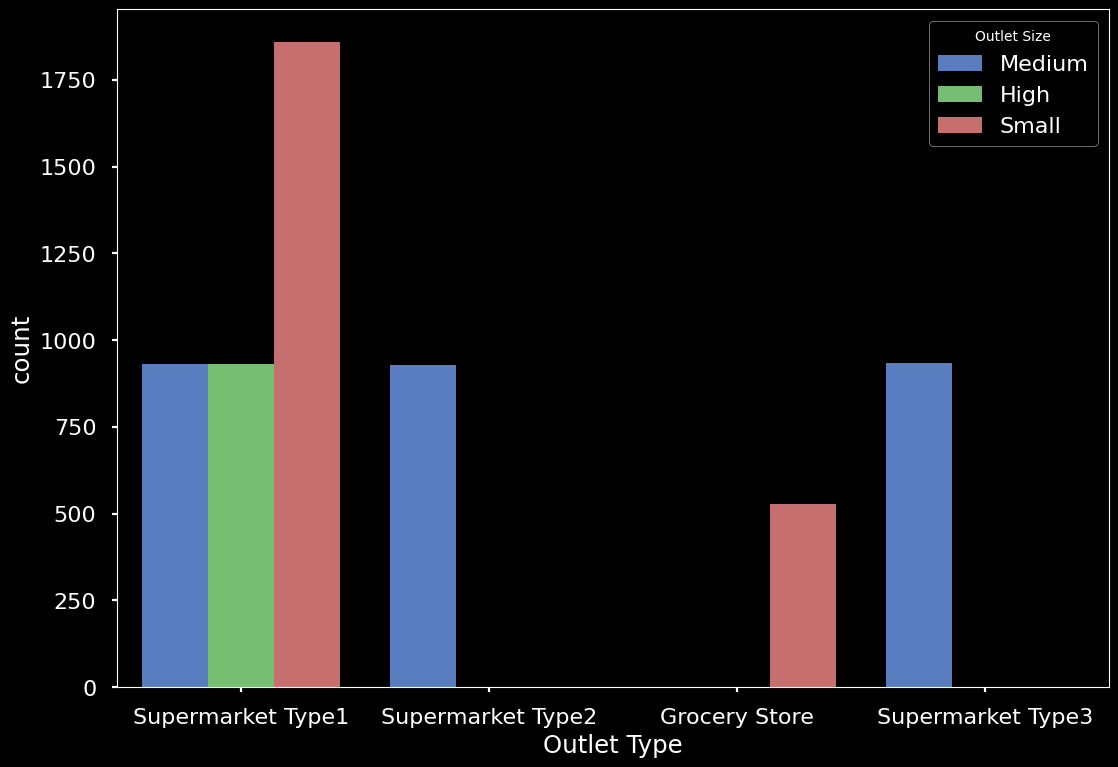

In [36]:
# Create a countplot to dtetermine relationship between Store Type and Store Size
ax = sns.countplot(data = df, x = 'Outlet Type', hue = "Outlet Size")

**We see that the majority of super Market Type 1 and *all* of Grocery Store values fall into the "Small" category.**

-  Next we will plot *Loc Type* against *Outlet Size*.

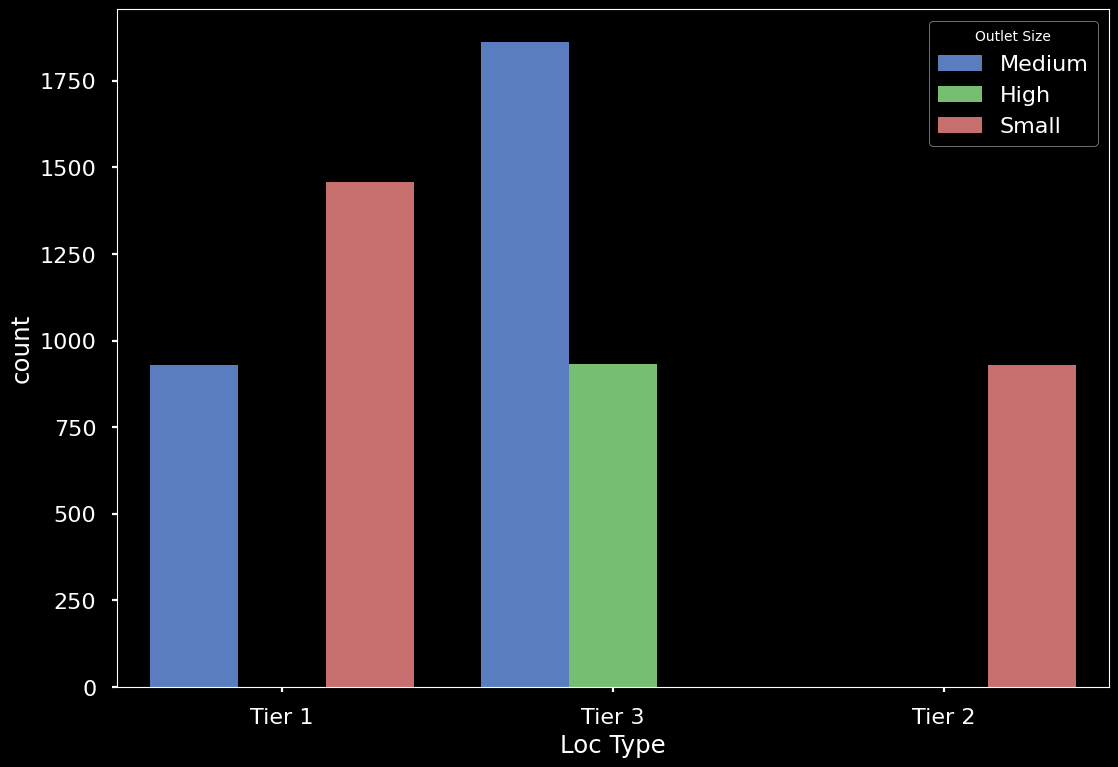

In [37]:
# Create a countplot to dtetermine relationship between Store Type and Store Size
ax = sns.countplot(data = df, x = 'Loc Type', hue = "Outlet Size")

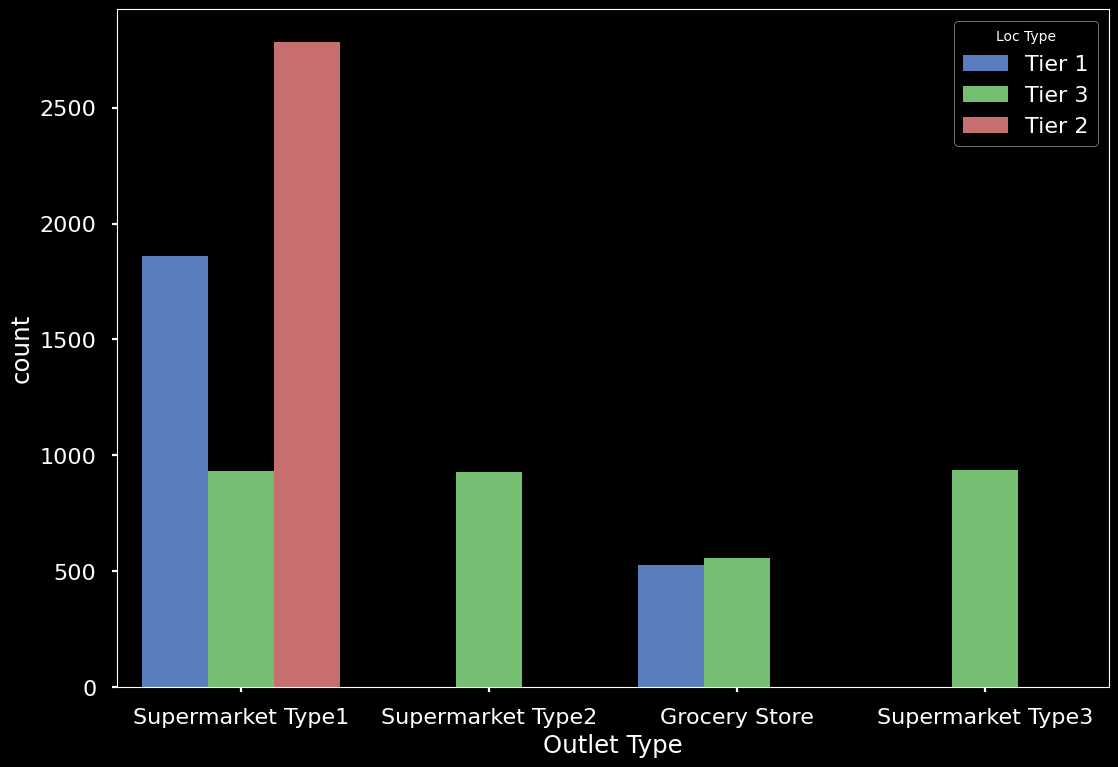

In [38]:
# Create a countplot to dtetermine relationship between Store Type and Store Size
ax = sns.countplot(data = df, x = 'Outlet Type', hue = "Loc Type")

**We can see that most "Supermarket Type 1" are at "Tier 2" *Loc Type.***

**We can now make the deduction that all 3 missing *Store Size* values should be set to "Small".**
- We can call the custom functions with the argument for placeholder set to "Small".

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Outlet Size vs. Total Sales'}, xlabel='Outlet Size', ylabel='Total Sales'>)

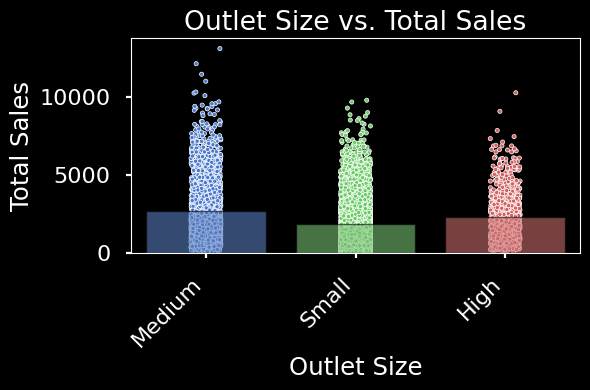

In [39]:
plot_categorical_vs_target(df, x= 'Outlet Size', placeholder="Small")

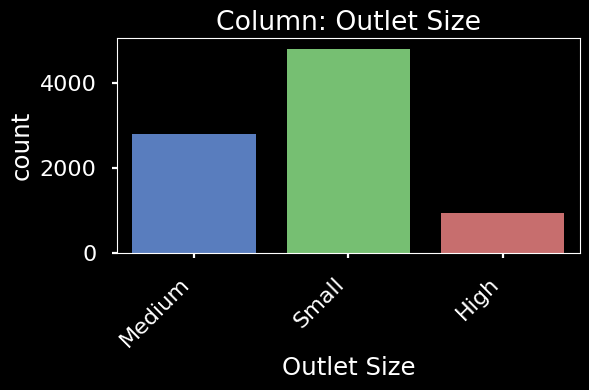

- NaN's Found: 2410 (28.28%)
- Unique Values: 3
- Most common value: 'Small' occurs 4798 times (56.29%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Outlet Size'}, xlabel='Outlet Size', ylabel='count'>)

In [40]:
explore_categorical(df, x = 'Outlet Size', placeholder="Small")


 -  We will convert the missing values to "Small" during regression modeling for more accurate modeling.
 -  We will also train our regression models with the default placehlder of "MISSING".

##  EDA(numeric)
- We will exlore each numeric feature.
- We will plot each numeric feature against the target.

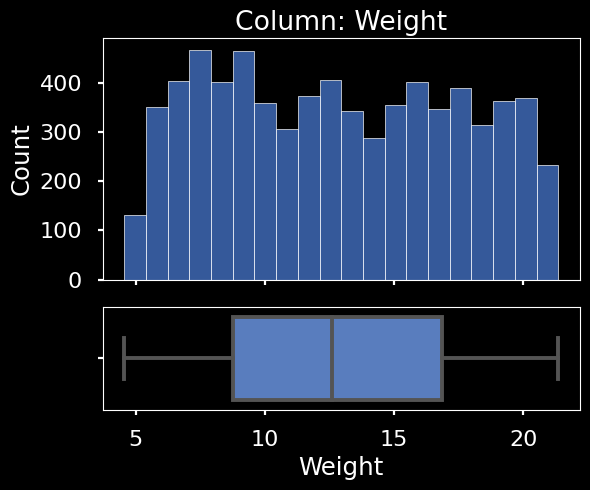

- NaN's Found: 1463 (17.17%)


In [41]:
explore_numeric(df, x = 'Weight')

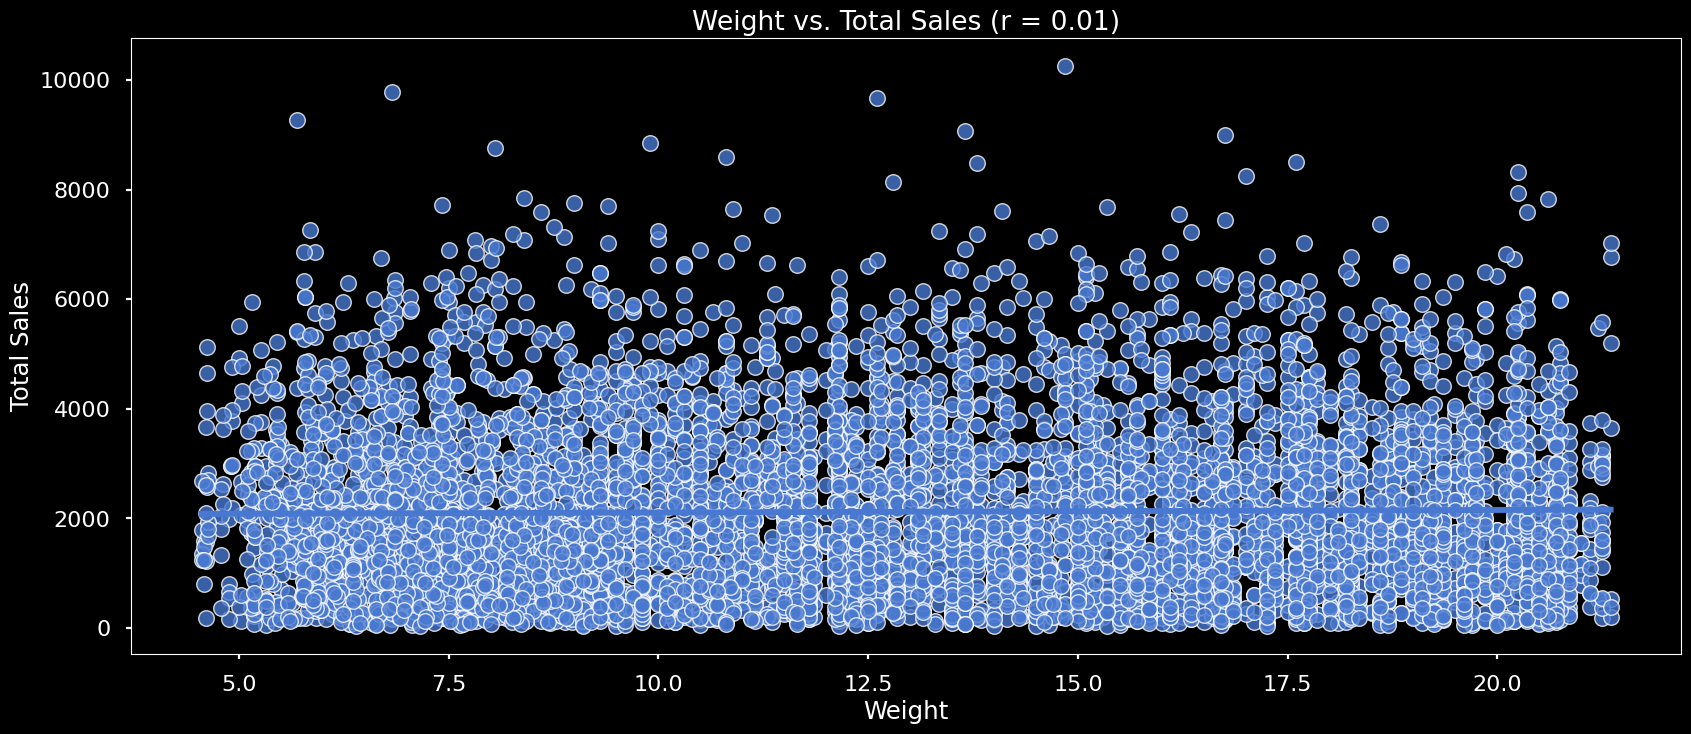

(<Figure size 2000x800 with 1 Axes>,
 <Axes: title={'center': 'Weight vs. Total Sales (r = 0.01)'}, xlabel='Weight', ylabel='Total Sales'>)

In [42]:
plot_numeric_vs_target(df, x = 'Weight', figsize =(20, 8))

**We see a ~flat correlation line.**(r = 0.01)
-  There are 1463 missing values, we will determine how to impute these missing values for modeling.

In [43]:
df['Weight'].value_counts()

12.150    86
17.600    82
13.650    77
11.800    76
15.100    68
          ..
7.275      2
7.685      1
9.420      1
6.520      1
5.400      1
Name: Weight, Length: 415, dtype: int64

In [44]:
df['Weight'].describe()


count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Weight, dtype: float64

**We see that the median value(12.6) is closest to the most common value(12.15)**.

-  we will impute the missing values in this category wth the median strategy during modeling.

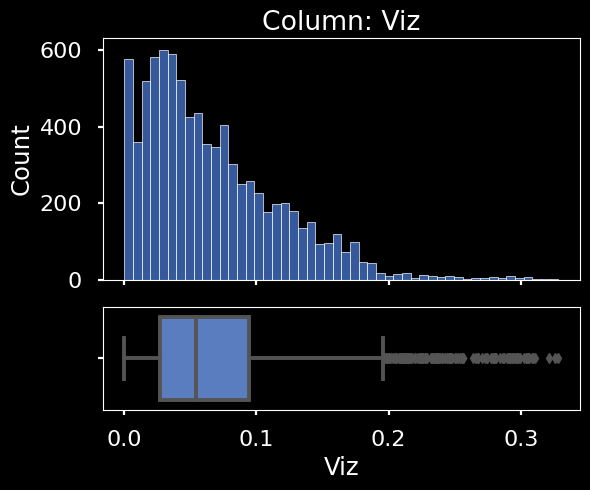

- NaN's Found: 0 (0.0%)


In [45]:
explore_numeric(df, x = 'Viz')

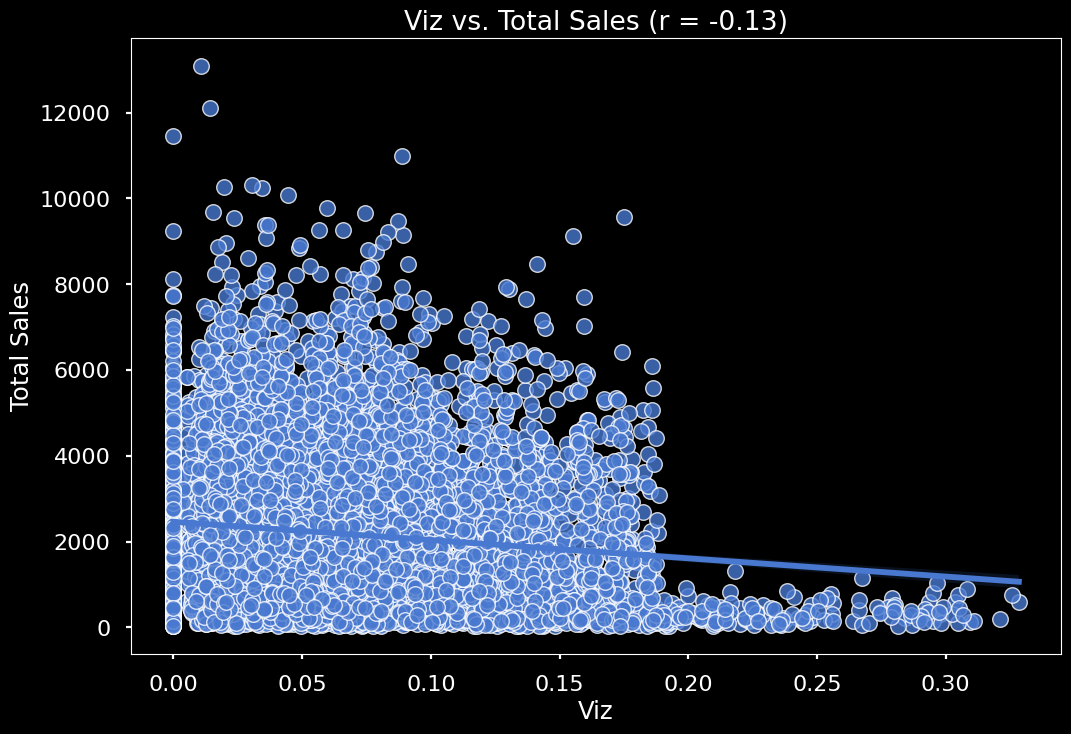

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Viz vs. Total Sales (r = -0.13)'}, xlabel='Viz', ylabel='Total Sales'>)

In [46]:
plot_numeric_vs_target(df, x = 'Viz', figsize =(12, 8))

**We see weak negative correlation.** (r = -0.13)

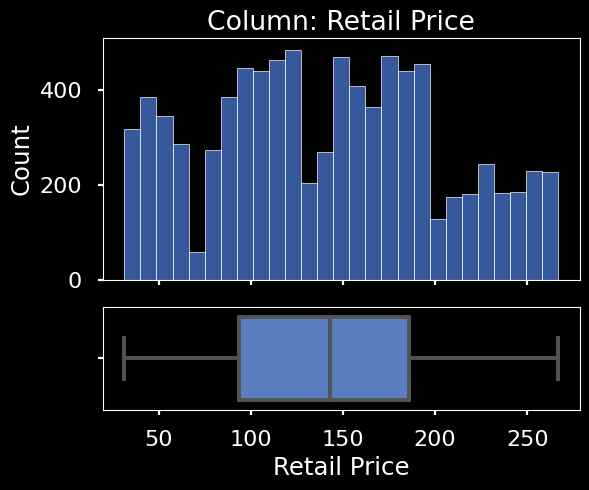

- NaN's Found: 0 (0.0%)


In [47]:
explore_numeric(df, x = 'Retail Price' )

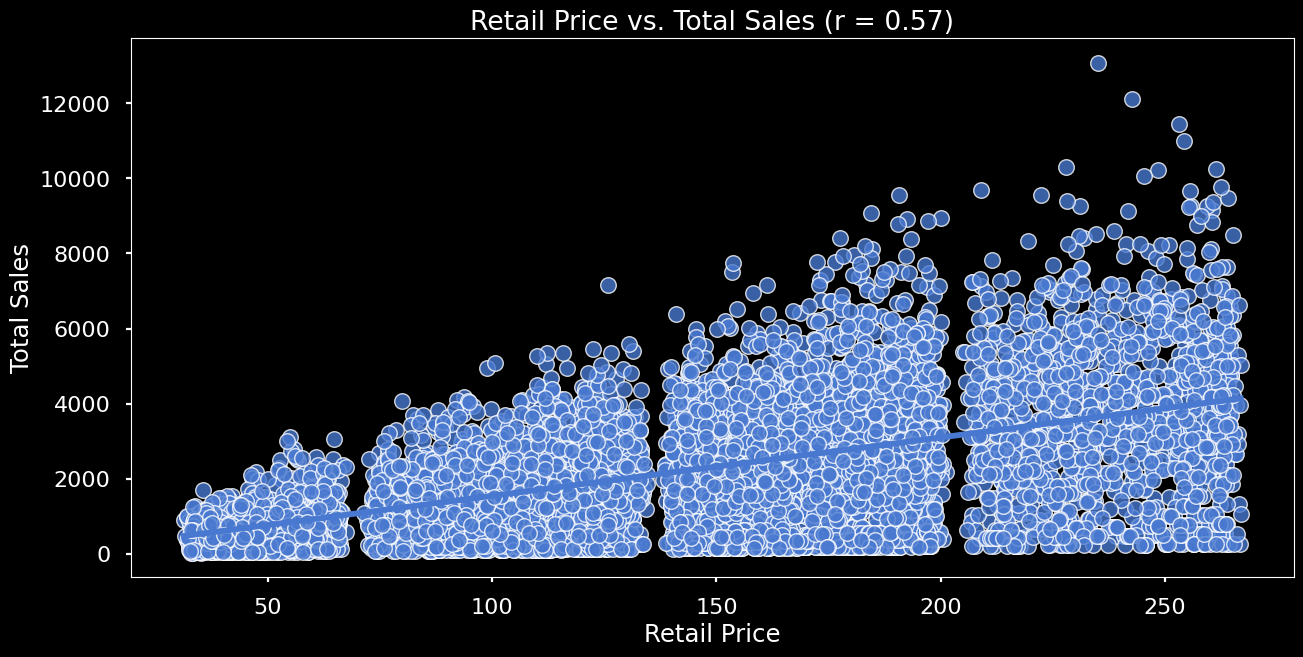

(<Figure size 1500x700 with 1 Axes>,
 <Axes: title={'center': 'Retail Price vs. Total Sales (r = 0.57)'}, xlabel='Retail Price', ylabel='Total Sales'>)

In [48]:
plot_numeric_vs_target(df, x = 'Retail Price', figsize = (15, 7))

**We see moderate positive correlation.**(r = 0.57)

**Correlation.**

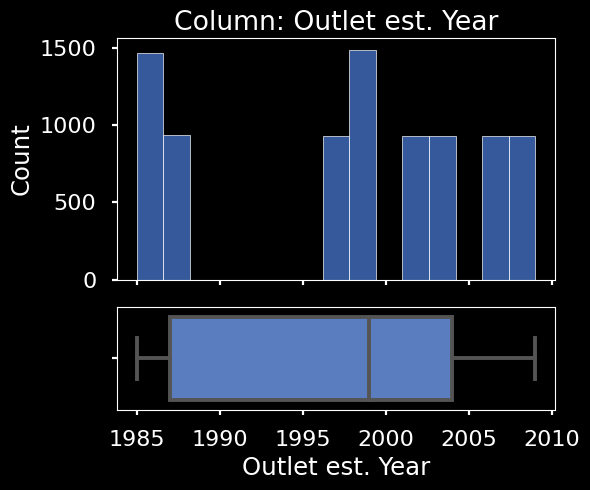

- NaN's Found: 0 (0.0%)


In [49]:
explore_numeric(df, x = 'Outlet est. Year')

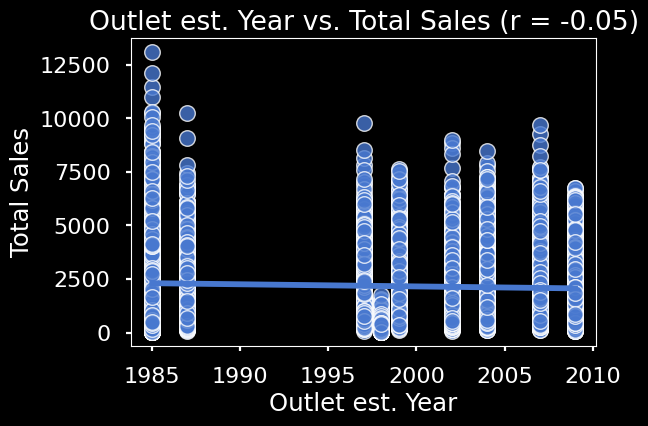

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Outlet est. Year vs. Total Sales (r = -0.05)'}, xlabel='Outlet est. Year', ylabel='Total Sales'>)

In [50]:
plot_numeric_vs_target(df, x = 'Outlet est. Year')

**We see weak negative correlation.**(r = -0.05)

In [51]:
# Create a list of number columns for easy reference
numeric_cols = df.select_dtypes("number").columns
numeric_cols

Index(['Weight', 'Viz', 'Retail Price', 'Outlet est. Year', 'Total Sales'], dtype='object')

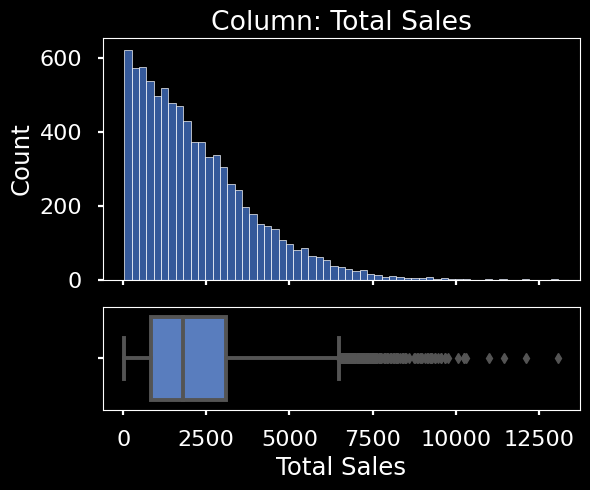

- NaN's Found: 0 (0.0%)


In [52]:
explore_numeric(df, x = 'Total Sales')

**This is our Target Vector.**

## Regression Evaluation
###   Copy data frame

In [53]:
df2 = df.copy()

###  Drop High cardinality columns
- Our EDA showed that we could drop *Product ID* and *Store ID* from our Regression model

In [54]:
df2 = df2.drop(columns = ['Product ID', 'Store ID'])

In [55]:
df2.head()

Weight Fat Content       Viz              Item Type  Retail Price  \
0    9.30     Low Fat  0.016047                  Dairy      249.8092   
1    5.92     Regular  0.019278            Soft Drinks       48.2692   
2   17.50     Low Fat  0.016760                   Meat      141.6180   
3   19.20     Regular  0.000000  Fruits and Vegetables      182.0950   
4    8.93     Low Fat  0.000000              Household       53.8614   

   Outlet est. Year Outlet Size Loc Type        Outlet Type  Total Sales  
0              1999      Medium   Tier 1  Supermarket Type1    3735.1380  
1              2009      Medium   Tier 3  Supermarket Type2     443.4228  
2              1999      Medium   Tier 1  Supermarket Type1    2097.2700  
3              1998         NaN   Tier 3      Grocery Store     732.3800  
4              1987        High   Tier 3  Supermarket Type1     994.7052

##  Regression Evaluation Functions

In [56]:
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )
  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

## Define Target & Features and Train Test Split

In [57]:
target = 'Total Sales'
y = df2[target]
X = df2.drop(columns=[target])

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# Check class balance
X_train.head()

Weight Fat Content       Viz     Item Type  Retail Price  \
4776  16.350     Low Fat  0.029565     Household      256.4646   
7510  15.250     Regular  0.000000   Snack Foods      179.7660   
5828  12.350     Regular  0.158716          Meat      157.2946   
5327   7.975     Low Fat  0.014628  Baking Goods       82.3250   
4810  19.350     Low Fat  0.016645  Frozen Foods      120.9098   

      Outlet est. Year Outlet Size Loc Type        Outlet Type  
4776              2009      Medium   Tier 3  Supermarket Type2  
7510              2009      Medium   Tier 3  Supermarket Type2  
5828              1999      Medium   Tier 1  Supermarket Type1  
5327              2004       Small   Tier 2  Supermarket Type1  
4810              2002         NaN   Tier 2  Supermarket Type1

In [59]:
y_train.head()

4776     515.3292
7510    3056.0220
5828    1577.9460
5327    1331.6000
4810    1687.1372
Name: Total Sales, dtype: float64

## PREPROCESSING PIPELINE FOR NUMERIC DATA

In [60]:
num_cols = X_train.select_dtypes('number').columns
num_cols

Index(['Weight', 'Viz', 'Retail Price', 'Outlet est. Year'], dtype='object')

In [61]:
impute_mean = SimpleImputer(strategy='median')

In [62]:
scaler = StandardScaler()

In [63]:
num_pipe = make_pipeline(impute_mean, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [64]:
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 Index(['Weight', 'Viz', 'Retail Price', 'Outlet est. Year'], dtype='object'))

## PREPROCESSING PIPELINE FOR ORDINAL DATA

In [65]:
ord_cols = ['Outlet Size']

In [66]:
# Specifying the order of categories in quality/condition columns
impute_na_ord = SimpleImputer(strategy='constant', fill_value='Small')
## Making the OrdinalEncoder
# Specifying order of categories for our  Ordinal Qual/Cond Columms
size_order = ['Small', 'Medium', 'High', 'MISSING']
# Making the list of order lists for OrdinalEncoder
ordinal_category_orders = [size_order]

ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)
# Making a final scaler to scale category #'s
scaler_ord = StandardScaler()

In [67]:
ord_pipe = make_pipeline(impute_na_ord, ord_encoder, scaler_ord)
ord_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='Small', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Small', 'Medium', 'High',
                                             'MISSING']])),
                ('standardscaler', StandardScaler())])

In [68]:
ord_tuple = ('ordinal', ord_pipe, ord_cols)
ord_tuple

('ordinal',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='Small', strategy='constant')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Small', 'Medium', 'High',
                                              'MISSING']])),
                 ('standardscaler', StandardScaler())]),
 ['Outlet Size'])

In [69]:
# Fit the pipeline on the training data
ord_pipe.fit(X_train[ord_cols])

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='Small', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Small', 'Medium', 'High',
                                             'MISSING']])),
                ('standardscaler', StandardScaler())])

In [70]:
# Transform the training and test data
X_train_ord_tf = ord_pipe.transform(X_train[ord_cols])
X_test_ord_tf = ord_pipe.transform(X_test[ord_cols])
X_train_ord_tf.head()

Outlet Size
4776     0.668862
7510     0.668862
5828     0.668862
5327    -0.799831
4810    -0.799831

## PREPROCESSING PIPELINE FOR CATAGORICAL DATA

In [71]:
cat_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns
cat_cols

Index(['Fat Content', 'Item Type', 'Loc Type', 'Outlet Type'], dtype='object')

In [72]:
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [73]:
cat_pipe = make_pipeline(ohe_encoder)
cat_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [74]:
cat_tuple = ('categorical', cat_pipe, cat_cols)
cat_tuple

('categorical',
 Pipeline(steps=[('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['Fat Content', 'Item Type', 'Loc Type', 'Outlet Type'], dtype='object'))

##  Column Transformer

In [75]:
col_transformer = ColumnTransformer ([num_tuple, cat_tuple, ord_tuple], verbose_feature_names_out=False)
col_transformer

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Weight', 'Viz', 'Retail Price', 'Outlet est. Year'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Fat Content', 'Item Type', 'Loc Type', 'Outlet Type'], dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Small',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'High',
                                                                              'MISSING']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet Size'])],
                  verbose_feature_names_out=False)

In [76]:
col_transformer.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Weight', 'Viz', 'Retail Price', 'Outlet est. Year'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Fat Content', 'Item Type', 'Loc Type', 'Outlet Type'], dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Small',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'High',
                                                                              'MISSING']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet Size'])],
                  verbose_feature_names_out=False)

In [77]:
X_train_processed = col_transformer.transform(X_train)
X_train_processed.head(2)

Weight       Viz  Retail Price  Outlet est. Year  Fat Content_Low Fat  \
4776  0.827485 -0.712775      1.828109          1.327849                  1.0   
7510  0.566644 -1.291052      0.603369          1.327849                  0.0   

      Fat Content_Regular  Item Type_Baking Goods  Item Type_Breads  \
4776                  0.0                     0.0               0.0   
7510                  1.0                     0.0               0.0   

      Item Type_Breakfast  Item Type_Canned  Item Type_Dairy  \
4776                  0.0               0.0              0.0   
7510                  0.0               0.0              0.0   

      Item Type_Frozen Foods  Item Type_Fruits and Vegetables  \
4776                     0.0                              0.0   
7510                     0.0                              0.0   

      Item Type_Hard Drinks  Item Type_Health and Hygiene  \
4776                    0.0                           0.0   
7510                    0.0                           0.0   

      Item Type_Household  Item Type_Meat  Item Type_Others  \
4776                  1.0             0.0               0.0   
7510                  0.0             0.0               0.0   

      Item Type_Seafood  Item Type_Snack Foods  Item Type_Soft Drinks  \
4776                0.0                    0.0                    0.0   
7510                0.0                    1.0                    0.0   

      Item Type_Starchy Foods  Loc Type_Tier 1  Loc Type_Tier 2  \
4776                      0.0              0.0              0.0   
7510                      0.0              0.0              0.0   

      Loc Type_Tier 3  Outlet Type_Grocery Store  \
4776              1.0                        0.0   
7510              1.0                        0.0   

      Outlet Type_Supermarket Type1  Outlet Type_Supermarket Type2  \
4776                            0.0                            1.0   
7510                            0.0                            1.0   

      Outlet Type_Supermarket Type3  Outlet Size  
4776                            0.0     0.668862  
7510                            0.0     0.668862

In [78]:
X_test_processed = col_transformer.transform(X_test)
X_test_processed.head(2)

Weight       Viz  Retail Price  Outlet est. Year  Fat Content_Low Fat  \
7503  0.341372 -0.776646     -0.998816         -1.293807                  1.0   
2957 -1.169135  0.100317     -1.585194         -0.102145                  1.0   

      Fat Content_Regular  Item Type_Baking Goods  Item Type_Breads  \
7503                  0.0                     0.0               0.0   
2957                  0.0                     0.0               0.0   

      Item Type_Breakfast  Item Type_Canned  Item Type_Dairy  \
7503                  0.0               0.0              0.0   
2957                  0.0               0.0              0.0   

      Item Type_Frozen Foods  Item Type_Fruits and Vegetables  \
7503                     1.0                              0.0   
2957                     0.0                              0.0   

      Item Type_Hard Drinks  Item Type_Health and Hygiene  \
7503                    0.0                           0.0   
2957                    0.0                           1.0   

      Item Type_Household  Item Type_Meat  Item Type_Others  \
7503                  0.0             0.0               0.0   
2957                  0.0             0.0               0.0   

      Item Type_Seafood  Item Type_Snack Foods  Item Type_Soft Drinks  \
7503                0.0                    0.0                    0.0   
2957                0.0                    0.0                    0.0   

      Item Type_Starchy Foods  Loc Type_Tier 1  Loc Type_Tier 2  \
7503                      0.0              0.0              0.0   
2957                      0.0              1.0              0.0   

      Loc Type_Tier 3  Outlet Type_Grocery Store  \
7503              1.0                        0.0   
2957              0.0                        0.0   

      Outlet Type_Supermarket Type1  Outlet Type_Supermarket Type2  \
7503                            1.0                            0.0   
2957                            1.0                            0.0   

      Outlet Type_Supermarket Type3  Outlet Size  
7503                            0.0     2.137555  
2957                            0.0    -0.799831

##  Modeling


###  Random Forest Model

In [79]:
rf = RandomForestRegressor(random_state=42)

In [80]:
rf_pipe = make_pipeline(col_transformer, rf)

In [81]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Weight', 'Viz', 'Retail Price', 'Outlet est. Year'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_o...
                                                  Index(['Fat Content', 'Item Type', 'Loc Type', 'Outlet Type'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Small',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'High',
                                                                                               'MISSING']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet Size'])],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [82]:
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 297.548
- MSE = 184,152.382
- RMSE = 429.130
- R^2 = 0.938

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 775.778
- MSE = 1,251,016.208
- RMSE = 1,118.488
- R^2 = 0.547




**The  default Random forest model Performed better on the *Training* data (R^2 = .938) than on the *Test* data, the R^2 of the *Test* data was  ~0.55**
-  This model is quite over fit.
 -  We will tune the model with gridsearchCV.


###  Use GridSearchCV to tune

In [83]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Weight', 'Viz', 'Retail Price', 'Outlet est. Year'], dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    Index(['Fat Content', 'Item Type', 'Loc Type', 'Outlet Type'], dtype='object')),
                                   ('ordinal',
                

In [84]:
# Instantiate default random forest model
rf = RandomForestRegressor(random_state = 42)
# define param grid with options to try
params = {'randomforestregressor__max_depth': [None,5,10],
          'randomforestregressor__n_estimators':[110,150,180],
          'randomforestregressor__min_samples_leaf':[4,5,6],
          'columntransformer__ordinal__simpleimputer__fill_value': ['Small', "MISSING"]}

In [85]:
gridsearch = GridSearchCV(rf_pipe, params, n_jobs = -1, cv = 4, verbose = 1)

In [ ]:
gridsearch.fit(X_train, y_train)

Fitting 4 folds for each of 54 candidates, totalling 216 fits


In [ ]:
gridsearch.best_params_

In [ ]:
best_rf = gridsearch.best_estimator_
evaluate_regression(best_rf, X_train, y_train, X_test, y_test)

**Our Tuned Model Has performed best on the *Test* data.**
-  With an R^2 of 0.604, the tuned model has the best fit of any model on the *Test* data.
- Our variance between the test and train Data has been almost eliminated.

In [ ]:
# Create Default Model
bagreg = BaggingRegressor(random_state = 42)
bagreg_pipe = make_pipeline(col_transformer, bagreg)
bagreg_pipe.fit(X_train, y_train)
# Use custom function to evaluate
evaluate_regression(bagreg_pipe, X_train, y_train, X_test, y_test)

In [ ]:
# Obtain list of parameters
bagreg_pipe.get_params()

In [ ]:
# Create a dictionary of hyperparameters to test
param_grid = {'baggingregressor__n_estimators': [45, 50, 55],
              'baggingregressor__max_samples' : [.5, .7, .9 ],
              'baggingregressor__max_features': [ .9 , 1],
              'columntransformer__ordinal__simpleimputer__fill_value': ['Small', "MISSING"]}

In [ ]:
gridsearch = GridSearchCV(bagreg_pipe, param_grid, n_jobs = -1, cv = 4, verbose = 1)

In [ ]:
gridsearch.fit(X_train, y_train)

In [ ]:
gridsearch.best_params_

In [ ]:
# Define a model with the best parameters already refit on the entire training set
best_bagreg_grid = gridsearch.best_estimator_
# Evalute the tuned model
evaluate_regression(best_bagreg_grid, X_train, y_train, X_test, y_test)

**The tuned model of the bagged forest outperformed the default model of the bagged forest however, the tuned model of the random forest is still our best performer**.

## CRISP-DM Phase 5 - Evaluation
-  We will use the tuned Version of the *Random Forest*
 -  With an MAE of ~728 it has performed the best of our models on the *Test* data.
  -  While each model performed better on the *Training* data than the *Test* data, our Tuned Model performed best across all regression metrics on the *Test* data.
   - Although our Tuned model was UnderFit, it had the best R^2 Rating of any of the models.